# **Debugging notebook**
### AUTHOR: Martí Cortada Garcia
---

In [1]:
# Required packages
from Bio import Phylo
from io import StringIO

#### **Example:** Expectation-Maximization (EM) for a {5-node-3-leaves}-tree following a General Markov Model (GMM) 
We have decided to work on the following tree:

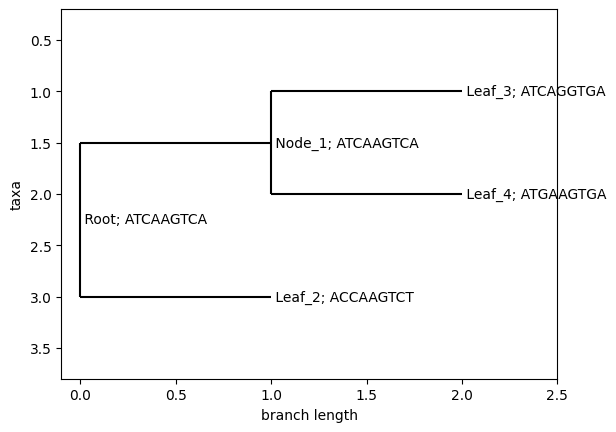

In [2]:
newick_tree = "((3,4),2)"
tree = Phylo.read(StringIO(newick_tree), "newick")
alignment = ["ATCAAGTCA", "ATCAAGTCA", "ACCAAGTCT", "ATCAGGTGA", "ATGAAGTGA"]

# Change nodes names
for idx, clade in enumerate(tree.get_nonterminals()):
    clade.name = "Node_" + str(idx) + "; " + alignment[1] if idx > 0 else "Root" + "; " + alignment[0]

# Change leaves names
for idx, clade in enumerate(tree.get_terminals()):
    clade.name = "Leaf_" + clade.name + "; " + alignment[int(clade.name)]

# Draw tree
Phylo.draw(tree)

Now, we must get all the required parameters for the model:

In [3]:
nodes = [0,1,2,3,4]                            # set of nodes
edges = [(0,1),(0,2),(1,3),(1,4)]              # set of edges
symbols = {"A":0, "C":1, "G":2, "T":3}         # set of symbols
alphabet = list(symbols.values())              # alphabet we will work with
N_obs = 3                                      # observed number of states
N_hid = 2                                      # hidden number of states

eps = 10**-3                                   # stopping criterion (epsilon)

In [4]:
import sys
from collections import Counter
from Bio import SeqIO

sequences = [i for i in SeqIO.parse('./alignments_4_leaves/length1000_a105_b105/length1000_a105_b105_num0.fa', 'fasta')]
print(sequences)

[SeqRecord(seq=Seq('ACCACCTCCTCATGAAAATCTGCATCGCTAAATTGTCATTCAGTCTTATTACTT...CGT'), id='1', name='1', description='1', dbxrefs=[]), SeqRecord(seq=Seq('GAGTACTGTTGAATGTTTTATTAATCTAGATGTCTGAGTTTGGAGCCAATTCGC...ATT'), id='2', name='2', description='2', dbxrefs=[]), SeqRecord(seq=Seq('GAGGTTGTAACAAATCGCACTCCTCGACCTAGGCTTATTAGATTACAAAAGGCA...AAT'), id='3', name='3', description='3', dbxrefs=[]), SeqRecord(seq=Seq('ACCGCTGACCGCGAGCACAAAGCCCCCCCTGCAGGGACGAGTCCAATCCGTCAC...GTG'), id='4', name='4', description='4', dbxrefs=[])]


In [5]:
seq = sequences[0].seq
v = []
str = ''
for k in range (len(seq)):
    str = seq[k]
    v.append(str)
counter = Counter(v) # Count ocurrences
freqs = dict(map(lambda x: (x[0], round(x[1]/1000, 5)), counter.items())) # From ocurrences to frequences
sorted_freqs = dict(sorted(freqs.items(), key=lambda x:x[1], reverse=True)) # Sort in descending order
[print(key,':',value) for key, value in sorted_freqs.items()]

C : 0.268
T : 0.268
G : 0.26
A : 0.204


[None, None, None, None]

In [25]:
import numpy as np

def generate_alignment(length, distribution):
    """
    Generates an alignment of length `length` using a given `distribution`.
    """
    seq = ''
    for i in range(length):
        # generate a random sample from the multinomial distribution
        nucleotide = np.random.choice(['A', 'C', 'G', 'T'], p=distribution)
        seq += nucleotide
    return seq

distribution = [0.25, 0.25, 0.25, 0.25] # equal distribution
alignment = generate_alignment(1000, distribution)
print(alignment)

TGATCAGCAAGCAAGGTGTCAAACCCCATCCATCGCACCCTCGCTTTGCAAAAATCCGAAACACGCGGGAGGACGCGTGCCATTGGATAACGAACAAAGTGCGACACTTCGTCCGGGAACCGGATAACGGGACAGGAGGAGGTACAGGTAACCGGTTTCTTTGAGATTACCTGTCGTTTGCACTCGATATCTGCTTTACTATAAACGTTTGATAGCCGGCGCGTAACGGGAGGTTTTCAAGTCGTGAGGATGGCCAACGTATAGTCAAACTCCTAGCTGGGCAGGGCCTGGAAGAACGAGGAAACTGGTCACCACTCTCGCGATGGCTTTGTACATTAGTCATTCATACTACCTCATTGGGAAAGTCATGGATCGCTACCCAGCCTAGGCGAGGACCACACGTAATGTTAAGCGTTTGGGGGTATTTCTTTACAAACCGTCTGTCAGTTCCAGTATAAACCACGCCCTTTATTTTCCGACAAGCACAGTATAGGTTCCGACGTAGTAGATGTAATCGACCTTACTGAGCGGGTGGGAGCAAACTGCGTGGTTCGCATTATTGGCGGGCTATTATAGATCTTTAAGCCGAAGCGGTAAACGGAGTAATCGGCAGTCCCTTGGAACCTGAGAGAATTCTTTAATTGCTCAAGGCGTCGAGCCCGGTGGCTTCGGACCTGTGACCGTAGAAGATAGAAAAGGTTCCTTGCCTGTATTAAGTACGCCGCTTCGTCCTCCTGCCTCGCCCGCTGGTCCTTGGTTGTGCTCCCGGATTCCCCTCTAATTCGATTTTGGTGGGCTTACCTAAGTACAAGTTTGTCCACGTCCTGGATTGTGCATCGATGTGTCAAGCACTATCTCAATAGACATCCATACGGCTATATTTCTAATGTTGCTACATGGCGGCCTCTTGCGGCTGTCGAAACACATGGCCTATAGTTTAGATTGGTACGGTCCGGCGTTGACAACACAGGACGATATTACGAGGCGGAATGAGAGCACG

In [7]:
counter = Counter(alignment) # Count ocurrences
freqs = dict(map(lambda x: (x[0], round(x[1]/1000, 5)), counter.items())) # From ocurrences to frequences
sorted_freqs = dict(sorted(freqs.items(), key=lambda x:x[1], reverse=True)) # Sort in descending order
[print(key,':',value) for key, value in sorted_freqs.items()]

T : 0.28
C : 0.244
G : 0.24
A : 0.236


[None, None, None, None]

In [8]:
# Define the nucleotides
nucleotides = ['A', 'C', 'G', 'T']

# Define the transition matrix
transition_matrix = np.zeros((4, 4))

# Define the two alignments
alignment1 = generate_alignment(1000, distribution)
alignment2 = generate_alignment(1000, distribution)

# Iterate over the alignments and count the transitions
for i in range(len(alignment1)-1):
    nucleotide1 = alignment1[i]
    nucleotide2 = alignment2[i+1]
    transition_matrix[nucleotides.index(nucleotide1)][nucleotides.index(nucleotide2)] += 1

# Normalize the transition matrix
transition_matrix /= np.sum(transition_matrix, axis=1, keepdims=True)

# Print the transition matrix
print(transition_matrix)

[[0.27272727 0.23320158 0.2687747  0.22529644]
 [0.25       0.22727273 0.24090909 0.28181818]
 [0.2779661  0.27118644 0.22372881 0.22711864]
 [0.28138528 0.22510823 0.28571429 0.20779221]]


In [9]:
def multiply_distribution_with_matrix(distribution, matrix):
    """
    Multiplies a distribution of nucleotides with a transition matrix.

    Args:
        distribution (ndarray): A 1D array of length 4 representing a distribution of nucleotides.
        matrix (ndarray): A 2D array of shape (4, 4) representing a transition matrix.

    Returns:
        ndarray: A 1D array of length 4 representing the resulting distribution of nucleotides.
    """
    return np.dot(distribution, matrix)

M = np.array(transition_matrix)
res = multiply_distribution_with_matrix(distribution, M)
print(res)

[0.27051966 0.23919224 0.25478172 0.23550637]


We define the transition probability matrices to generate the alignments:

In [10]:
import random

# Create transition probability matrices with suitable parameters  
def create_transition_probability_matrix(M): 
    for j in [0,1,2,3]:
        for i in [0,1,2,3]:
            if (i!=j): 
                M[(i,j)] = random.uniform(0.03,0.15)
    M[(0,0)] = 1 - M[(0,1)] - M[(0,2)] - M[(0,3)] 
    M[(1,1)] = 1 - M[(1,0)] - M[(1,2)] - M[(1,3)] 
    M[(2,2)] = 1 - M[(2,0)] - M[(2,1)] - M[(2,3)] 
    M[(3,3)] = 1 - M[(3,0)] - M[(3,1)] - M[(3,2)] 
    return(M)

M01 = create_transition_probability_matrix(np.zeros((4,4)))
M02 = create_transition_probability_matrix(np.zeros((4,4)))
M03 = create_transition_probability_matrix(np.zeros((4,4)))
M14 = create_transition_probability_matrix(np.zeros((4,4)))
M15 = create_transition_probability_matrix(np.zeros((4,4)))
MATRICES = [M01, M02, M03, M14, M15]
matrices_name = ['M01 = ', 'M02 = ', 'M03 = ', 'M14 = ', 'M15 = ']
for i in range(len(MATRICES)):
    print(matrices_name[i])
    print(MATRICES[i])


M01 = 
[[0.75686669 0.09323911 0.1087557  0.0411385 ]
 [0.10082056 0.66949911 0.13609911 0.09358122]
 [0.063027   0.09421526 0.75832669 0.08443105]
 [0.0305423  0.04262855 0.0635348  0.86329434]]
M02 = 
[[0.77242316 0.0870608  0.10973676 0.03077929]
 [0.11997433 0.72140754 0.03736257 0.12125555]
 [0.08421562 0.14279421 0.6249654  0.14802477]
 [0.04970847 0.05651992 0.10572335 0.78804827]]
M03 = 
[[0.72104538 0.12703312 0.03512575 0.11679574]
 [0.03561694 0.74924193 0.13317157 0.08196956]
 [0.12739085 0.13164854 0.66108148 0.07987914]
 [0.13389354 0.05024203 0.06667242 0.74919201]]
M14 = 
[[0.66698413 0.12244932 0.12491119 0.08565536]
 [0.09925091 0.66142233 0.14279239 0.09653437]
 [0.11136302 0.07189225 0.75012265 0.06662207]
 [0.04546718 0.08272644 0.09537145 0.77643493]]
M15 = 
[[0.73228947 0.04667774 0.14366504 0.07736775]
 [0.09852755 0.70452668 0.13149524 0.06545053]
 [0.09326761 0.14333763 0.72865567 0.0347391 ]
 [0.14753515 0.05221436 0.13734184 0.66290866]]


In [11]:
distribution = [0.25, 0.25, 0.25, 0.25] # equal distribution
alignment_root = generate_alignment(1000, distribution)

distribution1 = multiply_distribution_with_matrix(distribution, M01)
alignment1 = generate_alignment(1000, distribution1)

distribution2 = multiply_distribution_with_matrix(distribution, M02)
alignment2 = generate_alignment(1000, distribution2)

distribution3 = multiply_distribution_with_matrix(distribution, M03)
alignment3 = generate_alignment(1000, distribution3)

distribution4 = multiply_distribution_with_matrix(distribution1, M14)
alignment4 = generate_alignment(1000, distribution4)

distribution5 = multiply_distribution_with_matrix(distribution1, M15)
alignment5 = generate_alignment(1000, distribution5)

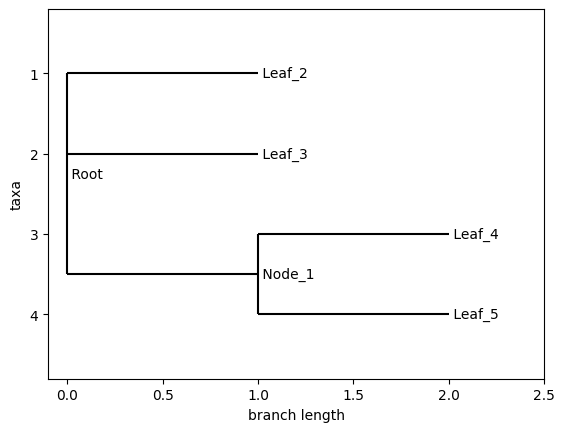

In [8]:
newick_tree = "(2,3,(4,5))"
tree = Phylo.read(StringIO(newick_tree), "newick")

# Change nodes names
for idx, clade in enumerate(tree.get_nonterminals()):
    clade.name = "Node_" + str(idx) if idx > 0 else "Root" 

# Change leaves names
for idx, clade in enumerate(tree.get_terminals()):
    clade.name = "Leaf_" + clade.name 

Phylo.draw(tree)

net = Phylo.to_networkx(tree) # to graph

In [164]:
from sympy import symbols, Eq, solve
from scipy.linalg import expm
new_distribution = [0.22, 0.24, 0.26, 0.28]

class Edge:
    def __init__(self, edge, transition_matrix=None):
        self.edge = edge
        self.transition_matrix = transition_matrix

node_distribution = dict()
node_distribution["Root"] = np.array([0.25]*4)
print(node_distribution["Root"])
l = 1

# Return a matrix from a dicrionary
def get_matrix_from_dict(d):
    Q2 = np.zeros((4,4))
    Q2[0,0] = np.double(d[A])
    Q2[0,1] = np.double(d[B])
    Q2[0,2] = np.double(d[C])
    Q2[0,3] = np.double(d[D])
    Q2[1,0] = np.double(d[E])
    Q2[1,1] = np.double(d[F])
    Q2[1,2] = np.double(d[G])
    Q2[1,3] = np.double(d[H])
    Q2[2,0] = np.double(d[I])
    Q2[2,1] = np.double(d[J])
    Q2[2,2] = np.double(d[K])
    Q2[2,3] = np.double(d[L])
    Q2[3,0] = np.double(d[M])
    Q2[3,1] = np.double(d[N])
    Q2[3,2] = np.double(d[O])
    Q2[3,3] = np.double(d[P])
    return Q2

def get_M2():
    A,B,C,D,E,F,G,H,I,J,K,L,M,N,O,P = symbols('A B C D E F G H I J K L M N O P')
    eq1 = Eq(A+B+C+D,0)
    eq2 = Eq(E+F+G+H,0)
    eq3 = Eq(I+J+K+L,0)
    eq4 = Eq(M+N+O+P,0)
    eq5 = Eq(A*new_distribution[0] + E*new_distribution[1] + I*new_distribution[2] + M*new_distribution[3],0)
    eq6 = Eq(B*new_distribution[0] + F*new_distribution[1] + J*new_distribution[2] + N*new_distribution[3],0)
    eq7 = Eq(C*new_distribution[0] + G*new_distribution[1] + K*new_distribution[2] + O*new_distribution[3],0)
    eq8 = Eq(D*new_distribution[0] + H*new_distribution[1] + L*new_distribution[2] + P*new_distribution[3],0)
    eq_traça = Eq(A+F+K+P,np.log(0.28438417141337796))
    eq9 = Eq(M,0.1)
    eq10 = Eq(N,0.1)
    eq11 = Eq(O,0.1)
    eq12 = Eq(I,0.1)
    eq13 = Eq(J,0.1)
    eq14 = Eq(L,0.1)
    eq15 = Eq(E,0.1)
    eq16 = Eq(H,0.1)
    sol = solve((eq1,eq2,eq3,eq4,eq5,eq6,eq7,eq8,eq_traça,eq9,eq10,eq11,eq12,eq13,eq14,eq15,eq16),(A,B,C,D,E,F,G,H,I,J,K,L,M,N,O,P))
    Q2 = get_matrix_from_dict(sol)
    M2 = expm(Q2)
    return M2
        
def generate_random_matrix(distribution):
    # Comentar...
    print('---'*30)
    res = 1
    while res >= 1:
        # Generant...
        M1 = np.zeros((4,4))
        i=0
        while i<4:
            R = np.random.dirichlet([1,1,1,1])
            if R[i] > 0.7 and R[i] < 0.8:
                M1[i,:] = R 
                i = i + 1

        new_distribution = np.matmul(distribution,M1)
        print('Comprovació 1:')
        D = np.diag(distribution)
        D_ = np.diag(new_distribution)
        res = np.exp(-l)*np.sqrt(np.linalg.det(D_))/np.sqrt(np.linalg.det(D))
        print("res", res)
        print('---'*30)
        print("Comprovació 2")
        detM1 = np.linalg.det(M1)
        print("DetM1 = ", detM1)
        if detM1 > np.exp(-l)*np.sqrt(np.linalg.det(D_))/np.sqrt(np.linalg.det(D)):
            pass
        else:
            res = 1
    print('---'*30)
    print("Creem M2")
    M2 = get_M2()
    print("M2 = ", M2)
    print('---'*30)
    print("Obtenim M")
    M = np.matmul(M1,M2)
    print("M = ", M)
    print('---'*30)
    print("Comprovem que d1·d2=detM")
    print("d1·d2 = ", np.linalg.det(M1)*np.linalg.det(M2))
    print("detM = ", np.linalg.det(M))

edges = []
root_ditribution = np.array([0.25]*4)
for edge in net.edges():
    new_edge = Edge(edge, generate_random_matrix(node_distribution[edge[0].name]))
    edges.append(new_edge)
    node_distribution[edge[1].name] = np.matmul(node_distribution[edge[0].name],new_edge.transition_matrix)
    print(new_edge.transition_matrix)
    assert(np.sum(new_edge.transition_matrix)==1)
    break


[0.25 0.25 0.25 0.25]
------------------------------------------------------------------------------------------
Comprovació 1:
res 0.3663852847951308
------------------------------------------------------------------------------------------
Comprovació 2
DetM1 =  0.2656247910885402
Comprovació 1:
res 0.36461145003110224
------------------------------------------------------------------------------------------
Comprovació 2
DetM1 =  0.24865230048115414
Comprovació 1:
res 0.3643786837370218
------------------------------------------------------------------------------------------
Comprovació 2
DetM1 =  0.32282966037711663
Comprovació 1:
res 0.3677901512681817
------------------------------------------------------------------------------------------
Comprovació 2
DetM1 =  0.2590804272412476
Comprovació 1:
res 0.3579440360792422
------------------------------------------------------------------------------------------
Comprovació 2
DetM1 =  0.321956025952612
Comprovació 1:
res 0.367244682

ValueError: matmul: Input operand 1 does not have enough dimensions (has 0, gufunc core with signature (n?,k),(k,m?)->(n?,m?) requires 1)